# Practica 3 COMPARACIÓN CPU VS GPU

### JORDI BLASCO LOZANO
### computacion de alto rendimiento

## Introducción 
En esta práctica, hemos explorado y comparado el rendimiento de una CPU y una GPU en la tarea de reconocimiento de imágenes utilizando un modelo de aprendizaje profundo preentrenado, ResNet18. El objetivo principal ha sido entender cómo la elección del hardware puede afectar significativamente el tiempo de procesamiento y cómo este conocimiento puede ser aplicado en proyectos reales.

## Objetivos de la Práctica

- Comparar los tiempos de ejecución en CPU y GPU para la tarea de procesamiento de imágenes.
- Reflexionar sobre cómo esta diferencia de rendimiento puede influir en aplicaciones del mundo real, como el reconocimiento facial.


## Pasos Realizados

### 1. Preparación del Entorno
- Instalacion e importacion de las bibliotecas necesarias
- Configuracion del debugger para que se puedan imprimir al nivel de log que se quiera (INFO, DEBUGG)

In [1]:
import torch
import time
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights
from PIL import Image
import sys
import os
import logging
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io

In [2]:
# nivel de log
DEBUG = True
INFO = True

log_level = logging.DEBUG if DEBUG else logging.INFO
logger = logging.getLogger()
logger.setLevel(log_level)

if not DEBUG:
    warnings.simplefilter("ignore", UserWarning)

if logger.hasHandlers():
    logger.handlers.clear()
handler = logging.StreamHandler()
handler.setLevel(log_level)
asctime_format = '%Y-%m-%d %H:%M:%S'
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s', datefmt=asctime_format)
handler.setFormatter(formatter)
logger.addHandler(handler)

logger.debug("Modo DEBUG activado")
logger.info("Modo INFO activado")

2025-02-11 19:33:58 - DEBUG - Modo DEBUG activado
2025-02-11 19:33:58 - INFO - Modo INFO activado


### 2. Carga de Bibliotecas y Modelo
- Comprobacion de si tenemos una gpu con cuda en el sistema
- Carga del modelo preentrenado ResNet18 y configuración en modo evaluación.
- Carga de imágenes de prueba.
- Aplicación de transformaciones a las imágenes para ajustarlas al tamaño requerido por el modelo.
- Medición del tiempo de procesamiento en CPU.
- Medición del tiempo de procesamiento en GPU (si está disponible).
- Registramos los tiempos de ejecucion de CPU y GPU y nos los guardamos en un dataset
- Exportamos el dataset a markdown para visualizarlo mejor


In [ ]:
class PracticaCPUvsGPU:
    def __init__(self):
        """
        Inicializa la práctica.
        """
        logging.debug("GPU disponible (inicial): %s", torch.cuda.is_available())
        logging.debug("Número de GPUs (inicial): %s", torch.cuda.device_count())
        
        # Definir las resoluciones a comparar
        self.resoluciones = [(224, 224), (512, 512), (1024, 1024), (2048, 2048), (4096, 4096)]
        
        # Cargar el modelo ResNet18 para CPU y establecerlo en modo evaluación
        self.model_cpu = models.resnet18(pretrained=True)
        self.model_cpu.eval()
        
        # Verificar GPU y cargar modelo en GPU si está disponible
        self.gpu_disponible = torch.cuda.is_available()
        if self.gpu_disponible:
            self.model_gpu = models.resnet18(pretrained=True).to('cuda')
            self.model_gpu.eval()
        else:
            self.model_gpu = None
        
        # Directorio donde se encuentran las imágenes
        self.imagenes_dir = "Fotos ejemplo"
        # Lista de rutas de imagen (Foto facial 1.jpg a Foto facial 5.jpg)
        self.image_paths = [os.path.join(self.imagenes_dir, f"Foto facial {i}.jpg") for i in range(1, 6)]
        
        # Inicialmente se crea un DataFrame vacío para almacenar los resultados.
        self.df = pd.DataFrame(columns=["imagen", "tamaño", "tiempo_cpu", "tiempo_gpu"])
    
    def run_measurements(self):
        """
        Recorre las imágenes y mide los tiempos de ejecución sobre CPU y GPU (si está disponible),
        registrando los resultados mediante logging y almacenándolos en un DataFrame.
        """
        resultados = []
        
        for path in self.image_paths:
            try:
                image = Image.open(path)
            except Exception as e:
                logging.error("Error al abrir la imagen %s: %s", path, e)
                # Se agrega una fila de error (una sola por imagen) tal como se hacía en el código original
                resultados.append({
                    "imagen": path,
                    "tamaño": f"Error al abrir imagen: {e}",
                    "tiempo_cpu": "-",
                    "tiempo_gpu": "-"
                })
                continue

            for res in self.resoluciones:
                # Definir la transformación para la resolución actual
                transform_res = transforms.Compose([
                    transforms.Resize(res),
                    transforms.ToTensor()
                ])
                
                # Convertir la imagen a tensor y añadir dimensión batch
                input_tensor = transform_res(image).unsqueeze(0)
                
                # Medición en CPU 
                start_cpu = time.time()
                with torch.no_grad():
                    _ = self.model_cpu(input_tensor)
                tiempo_cpu = time.time() - start_cpu
                
                resultado_log = f"Imagen: {path} | Tamaño: {res[0]}x{res[1]} | Tiempo en CPU: {tiempo_cpu:.4f} segundos"
                
                # Medición en GPU si está disponible
                if self.gpu_disponible:
                    input_tensor_gpu = input_tensor.to('cuda')
                    start_gpu = time.time()
                    with torch.no_grad():
                        _ = self.model_gpu(input_tensor_gpu)
                    torch.cuda.synchronize()  # Asegurarse de que la GPU finalice la operación
                    tiempo_gpu = time.time() - start_gpu
                    resultado_log += f" | Tiempo en GPU: {tiempo_gpu:.4f} segundos"
                    tiempo_gpu_val = tiempo_gpu
                else:
                    resultado_log += " | GPU no disponible."
                    tiempo_gpu_val = "-"
                
                logging.info(resultado_log)
                
                # Se agrega el resultado al listado; para la tabla se usa el nombre base de la imagen.
                resultados.append({
                    "imagen": os.path.basename(path),
                    "tamaño": f"{res[0]}x{res[1]}",
                    "tiempo_cpu": tiempo_cpu,
                    "tiempo_gpu": tiempo_gpu_val
                })
        
        # Se crea el DataFrame a partir de la lista de resultados.
        self.df = pd.DataFrame(resultados)
    
    def generar_tabla_markdown(self) -> str:
        
        return self.df.to_markdown()
    
    def run_all(self):
        """
        Ejecuta el análisis (mediciones) y genera la tabla Markdown.
        """
        self.run_measurements()
        md_table = self.generar_tabla_markdown()
        
        return md_table
    


### 3 Ejecucion del modelo
- Carga de la clase en una variable
- Ejecucion del programa y guardado de la tabla de markdonw en una variable, (aunque tengamos el dataset de pandas para mostrar la tabla mejor cogemos la tabla de markdown)


In [20]:
practica = PracticaCPUvsGPU()

tabla_md = practica.run_all()

logging.debug("Tabla Markdown generada:\n%s", tabla_md)


2025-02-11 19:57:09 - DEBUG - GPU disponible (inicial): True
2025-02-11 19:57:09 - DEBUG - Número de GPUs (inicial): 1
2025-02-11 19:57:09 - INFO - Imagen: Fotos ejemplo\Foto facial 1.jpg | Tamaño: 224x224 | Tiempo en CPU: 0.0165 segundos | Tiempo en GPU: 0.0040 segundos
2025-02-11 19:57:09 - INFO - Imagen: Fotos ejemplo\Foto facial 1.jpg | Tamaño: 512x512 | Tiempo en CPU: 0.0570 segundos | Tiempo en GPU: 0.0030 segundos
2025-02-11 19:57:09 - INFO - Imagen: Fotos ejemplo\Foto facial 1.jpg | Tamaño: 1024x1024 | Tiempo en CPU: 0.2281 segundos | Tiempo en GPU: 0.0100 segundos
2025-02-11 19:57:10 - INFO - Imagen: Fotos ejemplo\Foto facial 1.jpg | Tamaño: 2048x2048 | Tiempo en CPU: 0.9193 segundos | Tiempo en GPU: 0.0365 segundos
2025-02-11 19:57:15 - INFO - Imagen: Fotos ejemplo\Foto facial 1.jpg | Tamaño: 4096x4096 | Tiempo en CPU: 4.0635 segundos | Tiempo en GPU: 0.1420 segundos
2025-02-11 19:57:15 - INFO - Imagen: Fotos ejemplo\Foto facial 2.jpg | Tamaño: 224x224 | Tiempo en CPU: 0.0180

|    | imagen            | tamaño    |   tiempo_cpu |   tiempo_gpu |
|---:|:------------------|:----------|-------------:|-------------:|
|  0 | Foto facial 1.jpg | 224x224   |    0.0165162 |   0.00399995 |
|  1 | Foto facial 1.jpg | 512x512   |    0.0570023 |   0.00300217 |
|  2 | Foto facial 1.jpg | 1024x1024 |    0.228137  |   0.00999689 |
|  3 | Foto facial 1.jpg | 2048x2048 |    0.91932   |   0.0364637  |
|  4 | Foto facial 1.jpg | 4096x4096 |    4.06353   |   0.142001   |
|  5 | Foto facial 2.jpg | 224x224   |    0.0180011 |   0.00299835 |
|  6 | Foto facial 2.jpg | 512x512   |    0.0573187 |   0.00300097 |
|  7 | Foto facial 2.jpg | 1024x1024 |    0.226626  |   0.00999618 |
|  8 | Foto facial 2.jpg | 2048x2048 |    0.895709  |   0.034209   |
|  9 | Foto facial 2.jpg | 4096x4096 |    4.11482   |   0.140002   |
| 10 | Foto facial 3.jpg | 224x224   |    0.0170014 |   0.00400043 |
| 11 | Foto facial 3.jpg | 512x512   |    0.0569983 |   0.00299788 |
| 12 | Foto facial 3.jpg | 1024x1024 |    0.228017  |   0.00899744 |
| 13 | Foto facial 3.jpg | 2048x2048 |    0.891399  |   0.032999   |
| 14 | Foto facial 3.jpg | 4096x4096 |    4.11287   |   0.142001   |
| 15 | Foto facial 4.jpg | 224x224   |    0.0170004 |   0.00399685 |
| 16 | Foto facial 4.jpg | 512x512   |    0.0570011 |   0.00299907 |
| 17 | Foto facial 4.jpg | 1024x1024 |    0.226554  |   0.00899839 |
| 18 | Foto facial 4.jpg | 2048x2048 |    0.865997  |   0.0329978  |
| 19 | Foto facial 4.jpg | 4096x4096 |    4.04203   |   0.140606   |
| 20 | Foto facial 5.jpg | 224x224   |    0.0180049 |   0.00400043 |
| 21 | Foto facial 5.jpg | 512x512   |    0.0579977 |   0.00400496 |
| 22 | Foto facial 5.jpg | 1024x1024 |    0.235649  |   0.00899839 |
| 23 | Foto facial 5.jpg | 2048x2048 |    0.860167  |   0.0329986  |
| 24 | Foto facial 5.jpg | 4096x4096 |    4.07685   |   0.139999   |

###  4 Uso de un pandas dataset y luego calcular las medias de cada tamaño de imagen para la CPU y GPU

- Copiamos el dataset de la clase anterior que estabamos usando en una nueva variable global
- Si tenemos valores de `-` en los datos de la GPU porque no haya GPU los cambiamos por `np.nan` para que no de error al pasarlos a numeros 
- Calculamos las medias y nos las guardamos en orden de menor tamaño de imagen a mayor sacando el entero de la string `tamaño` y creando una nueva variable que ordena el df para luego eliminar la columna auxiliar

In [25]:
# Copiamos el DataFrame para no modificar el original
df = practica.df.copy()

# Convertir las columnas de tiempos a numérico:
# Si en algún caso se hubiera almacenado "-" (por ejemplo, en 'tiempo_gpu' cuando la GPU no está disponible),
# lo reemplazamos por NaN.
df['tiempo_cpu'] = pd.to_numeric(df['tiempo_cpu'], errors='coerce')
df['tiempo_gpu'] = df['tiempo_gpu'].replace("-", np.nan)
df['tiempo_gpu'] = pd.to_numeric(df['tiempo_gpu'], errors='coerce')

# Calcular la media de los tiempos agrupando por 'tamaño'
mean_times = df.groupby('tamaño')[['tiempo_cpu', 'tiempo_gpu']].mean().reset_index()

# Para ordenar de forma numérica, extraemos el ancho a partir del string (formato "anchoxalto")
mean_times['size_num'] = mean_times['tamaño'].apply(lambda s: int(s.split("x")[0]) if "x" in s else None)

# Ordenar los datos de menor a mayor según el ancho extraído y eliminar la columna auxiliar
mean_times = mean_times.sort_values('size_num').drop('size_num', axis=1).reset_index(drop=True)

logging.debug("Media calculada")
logging.info(f"Media de tiempos por tamaño:\n{mean_times}")




2025-02-11 20:09:39 - DEBUG - Media calculada
2025-02-11 20:09:39 - INFO - Media de tiempos por tamaño:
      tamaño  tiempo_cpu  tiempo_gpu
0    224x224    0.017305    0.003799
1    512x512    0.057264    0.003201
2  1024x1024    0.228997    0.009397
3  2048x2048    0.886518    0.033934
4  4096x4096    4.082020    0.140922


### 4 Metricas nuevas y plots de datos
- Dividimos la media de tiempo de CPU entre el tiempo de ejecucion de GPU y sacamos la cantidad de veces que la GPU es más rapida que la CPU

`nota`**Si no tenemos GPU no podremos generar un plot nuevo**

2025-02-11 20:10:21 - INFO - Numero de veces mas rapido la GPU que la CPU 
       tamaño  Veces mas rapido
0    224x224          4.554854
1    512x512         17.889245
2  1024x1024         24.367929
3  2048x2048         26.125058
4  4096x4096         28.966577


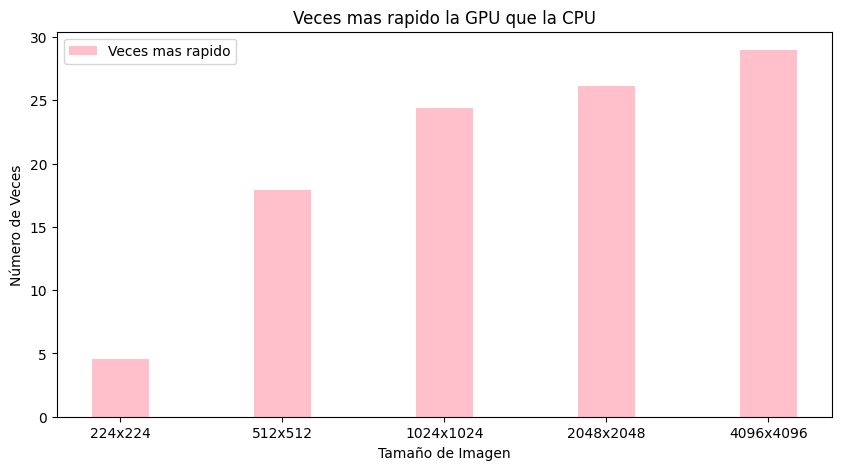

2025-02-11 20:10:21 - DEBUG - Gráfico 1 mostrado. 


In [27]:


mean_times['Total (s)'] = mean_times['tiempo_cpu'] + mean_times['tiempo_gpu']
mean_times['Veces mas rapido'] = mean_times['tiempo_cpu'] / mean_times['tiempo_gpu']

logs_a_mostrar = mean_times[['tamaño', 'Veces mas rapido']]
logger.info(f"Numero de veces mas rapido la GPU que la CPU \n {logs_a_mostrar}")

positions = np.arange(len(mean_times))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(positions , mean_times['Veces mas rapido'], width, color='pink',  label='Veces mas rapido')

plt.xlabel('Tamaño de Imagen')
plt.ylabel('Número de Veces')
plt.title('Veces mas rapido la GPU que la CPU')
plt.xticks(positions, mean_times['tamaño'])
plt.legend()
plt.show()
logger.debug("Gráfico 1 mostrado. ")


### 5 Plot final
- Generamos un plot con la media de cada tamaño de imagen con puntos y luego las unimos con una linea para la CPU y otra para la GPU

2025-02-11 20:11:30 - INFO - Media de datos 
       tamaño  tiempo_cpu  tiempo_gpu
0    224x224    0.017305    0.003799
1    512x512    0.057264    0.003201
2  1024x1024    0.228997    0.009397
3  2048x2048    0.886518    0.033934
4  4096x4096    4.082020    0.140922


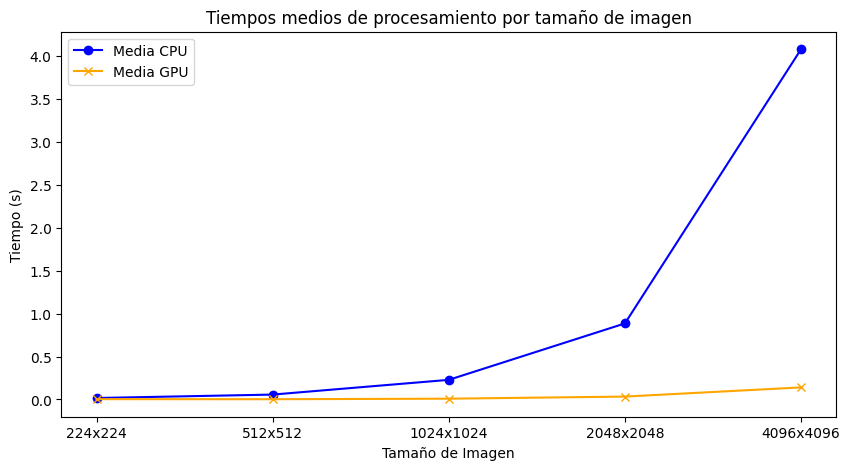

2025-02-11 20:11:30 - DEBUG - Gráfico 2 mostrado.


In [31]:

logs_a_mostrar = mean_times[['tamaño', 'tiempo_cpu', 'tiempo_gpu']]
logger.info(f"Media de datos \n {logs_a_mostrar}")

plt.figure(figsize=(10, 5))
plt.plot(mean_times['tamaño'], mean_times['tiempo_cpu'], marker='o', linestyle='-', color='blue', label='Media CPU')
plt.plot(mean_times['tamaño'], mean_times['tiempo_gpu'], marker='x', linestyle='-', color='orange', label='Media GPU')
plt.xlabel('Tamaño de Imagen')
plt.ylabel('Tiempo (s)')
plt.title('Tiempos medios de procesamiento por tamaño de imagen')
plt.legend()
plt.show()
logger.debug("Gráfico 2 mostrado.")

## CONCLUSIONES